Comparing 5 models via LOO Validation...


/Users/yizhen/miniforge3/envs/myenv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yizhen/miniforge3/envs/myenv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yizhen/miniforge3/envs/myenv/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/yizhen

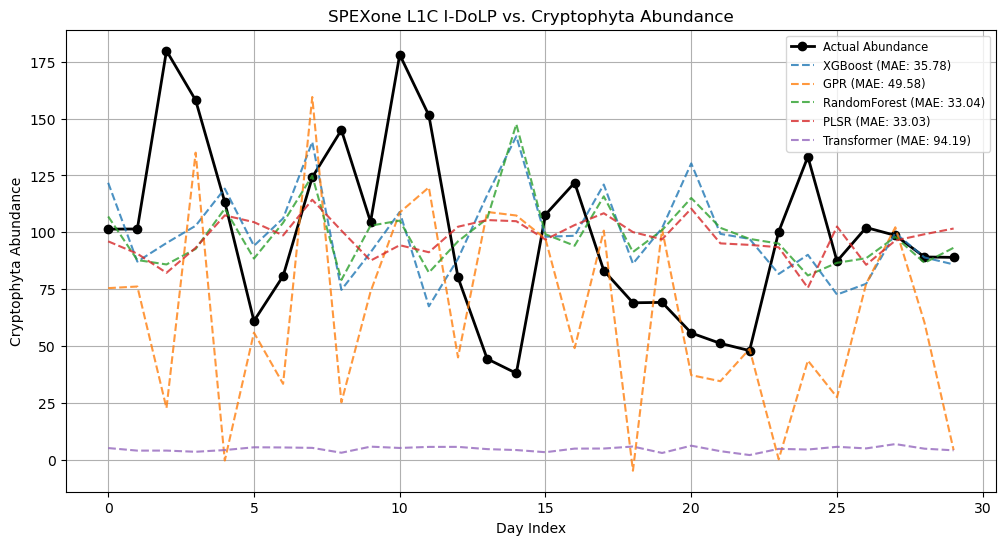

In [12]:
#If we only have small datasets, please consider 
#XGBoost and random forest regression or classification models. 


import numpy as np
import pandas as pd
import xgboost as xgb
import torch
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression  # New import

# ==========================================
# 1. DATA LOADING & PRE-PROCESSING
# ==========================================
df = pd.read_csv('mvco-cryp-spex-i-dolp-jul.csv')
columns_to_use = list(range(2, 402)) # use intensity only
#columns_to_use = list(range(2, 450)) # use intensity and dolp
X_raw = df.iloc[:, columns_to_use]
y_raw = df['cryp'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

# ==========================================
# 2. TRANSFORMER MODEL DEFINITION (PyTorch)
# ==========================================
class SimpleTransformer(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # Small transformer for tabular data
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=1, dim_feedforward=16, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.regressor = nn.Linear(input_dim, 1)

    def forward(self, x):
        # Add a dummy sequence dimension for the transformer [batch, seq_len, features]
        x = x.unsqueeze(1)
        x = self.transformer(x)
        return self.regressor(x.squeeze(1))

# ==========================================
# 3. VALIDATION FRAMEWORK
# ==========================================
loo = LeaveOneOut()
model_names = ['XGBoost', 'GPR', 'RandomForest', 'PLSR', 'Transformer']
results = {name: [] for name in model_names}
actuals = []

print(f"Comparing {len(model_names)} models via LOO Validation...")

for train_index, test_index in loo.split(X_pca):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y_raw[train_index], y_raw[test_index]
    actuals.append(y_test[0])

    # --- 1. XGBoost (with Bagging) ---
    base_xgb = xgb.XGBRegressor(max_depth=2, learning_rate=0.1, objective='reg:squarederror')
    xgb_model = BaggingRegressor(estimator=base_xgb, n_estimators=10)
    xgb_model.fit(X_train, y_train)
    results['XGBoost'].append(xgb_model.predict(X_test)[0])

    # --- 2. Gaussian Process Regression (GPR) ---
    kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
    gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp_model.fit(X_train, y_train)
    results['GPR'].append(gp_model.predict(X_test)[0])

    # --- 3. Random Forest ---
    rf_model = RandomForestRegressor(n_estimators=50, max_depth=3, random_state=42)
    rf_model.fit(X_train, y_train)
    results['RandomForest'].append(rf_model.predict(X_test)[0])

    # --- 4. Partial Least Square Regression (PLSR) ---
    pls_model = PLSRegression(n_components=2, scale=False) # PCA is 3, so n_components should be <= 3
    pls_model.fit(X_train, y_train)
    results['PLSR'].append(pls_model.predict(X_test).item())

    # --- 5. Transformer ---
    t_model = SimpleTransformer(input_dim=3)
    optimizer = torch.optim.Adam(t_model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    
    # Simple training loop for 50 epochs
    X_t = torch.FloatTensor(X_train)
    y_t = torch.FloatTensor(y_train).view(-1, 1)
    for _ in range(50):
        optimizer.zero_grad()
        output = t_model(X_t)
        loss = criterion(output, y_t)
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        t_pred = t_model(torch.FloatTensor(X_test)).item()
        results['Transformer'].append(t_pred)

# ==========================================
# 4. RESULTS & VISUALIZATION
# ==========================================
plt.figure(figsize=(12, 6))
plt.plot(actuals, 'k-', label='Actual Abundance', linewidth=2, marker='o')

for name in model_names:
    mae = mean_absolute_error(actuals, results[name])
    plt.plot(results[name], '--', label=f'{name} (MAE: {mae:.2f})', alpha=0.8)

plt.title('SPEXone L1C I vs. Cryptophyta Abundance')
#plt.title('SPEXone L1C I-DoLP vs. Cryptophyta Abundance')
plt.ylabel('Cryptophyta Abundance')
plt.xlabel('Day Index')
plt.legend(loc='upper right', fontsize='small', frameon=True)
plt.grid(True)

plt.show()